In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from tqdm import tqdm
import os
os.environ["KERAS_BACKEND"] = "jax" 


import keras
from VisionTransformer import Patches, PatchEncoder
import cv2
import matplotlib.patches as patches

In [2]:
padchest_masks = pd.read_csv("../Data/chexmask-cxr-segmentation-data/0.2/Preprocessed/Padchest.csv")

In [3]:
padchest_masks = padchest_masks.dropna()

In [4]:
padchest_masks.head()

,ImageID,Dice RCA (Mean),Dice RCA (Max),Landmarks,Left Lung,Right Lung,Heart,Height,Width
0,216840111366964012487858717522009278090344349_...,0.800701,0.837323,"416,179,367,183,318,194,271,210,232,230,201,25...",198318 6 199335 19 200353 31 201370 43 202390 ...,183707 10 184719 28 185731 46 186743 64 187758...,395806 40 396825 51 397844 62 398864 72 399883...,1024.0,1024.0
1,297296042610568106386358000944101882216_oryw2k...,0.827260,0.865835,"363,186,328,190,291,211,254,240,220,274,191,31...",184917 8 185930 23 186943 38 187961 48 188983 ...,190824 6 191839 18 192855 29 193870 40 194889 ...,507351 32 508370 50 509388 72 510407 87 511427...,1024.0,1024.0
2,282304671682231211691601927052092320690_fqq20r...,0.829237,0.871887,"430,247,397,248,362,264,328,285,298,309,271,33...",249448 7 250469 20 251491 32 252512 42 253533 ...,253343 18 254349 40 255371 46 256393 51 257415...,522740 28 523758 40 524776 52 525794 64 526814...,1024.0,1024.0
3,216840111366964012558082906712010118092605469_...,0.812057,0.836466,"377,201,341,204,305,221,274,245,250,272,234,30...",208469 39 209491 45 210512 51 211534 56 212556...,206197 8 207209 24 208221 41 209237 53 210259 ...,503271 28 504291 38 505311 48 506331 58 507351...,1024.0,1024.0
4,216840111366964012487858717522009264132859659_...,0.802433,0.912305,"413,93,380,96,344,113,308,139,275,173,250,207,...",90741 5 91760 16 92779 26 93798 37 94816 48 95...,95641 7 96654 21 97667 35 98684 46 99706 51 10...,408071 33 409082 54 410104 62 411126 68 412147...,1024.0,1024.0


In [5]:
def rle2mask(mask_rle: str, label=1, shape=(3520,4280)):
    """
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = label
    return img.reshape(shape)# Needed to align to RLE direction


def decode_both_lungs(row, label=1):

    right = rle2mask(
        mask_rle=row["Right Lung"],
        label=label,
        shape=(int(row["Height"]),int(row["Width"]))
    )

    left = rle2mask(
        mask_rle=row["Left Lung"],
        label=label,
        shape=(int(row["Height"]),int(row["Width"]))
    )

    return right + left

def bounding_box(image, label=1):
    _image = image.copy()
    segmentation = np.where(_image == label)

    if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
        x_min = int(np.min(segmentation[1]))
        x_max = int(np.max(segmentation[1]))
        y_min = int(np.min(segmentation[0]))
        y_max = int(np.max(segmentation[0]))

    return (x_min, y_min, x_max, y_max)

In [7]:
bbox = list()
for i in tqdm(range(len(padchest_masks))):
    bbox.append(bounding_box(np.array(Image.fromarray(decode_both_lungs(padchest_masks.iloc[i])).resize((512,512)))))
padchest_masks["bbox_512"] = bbox

 34%|███▍      | 33349/97909 [05:19<10:17, 104.50it/s]


KeyboardInterrupt: 

In [ ]:
padchest_df = pd.read_csv("../Data/preprocessed_df.csv", index_col=0)

In [ ]:
test_set_masks = pd.merge(padchest_masks, padchest_df, how="inner", on= "ImageID")

In [ ]:
test_set_masks.head()

,ImageID,Dice RCA (Mean),Dice RCA (Max),Landmarks,Left Lung,Right Lung,Heart,Height,Width,bbox_512,...,ExposureTime,RelativeXRayExposure_DICOM,ReportID,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,216840111366964012487858717522009278090344349_...,0.800701,0.837323,"416,179,367,183,318,194,271,210,232,230,201,25...",198318 6 199335 19 200353 31 201370 43 202390 ...,183707 10 184719 28 185731 46 186743 64 187758...,395806 40 396825 51 397844 62 398864 72 399883...,1024.0,1024.0,"(32, 89, 482, 344)",...,NaN,NaN,3703392,via central yugul derech termi . . do ven cav...,RNN_model,"['central venous catheter via jugular vein', '...","['loc right', 'loc left', 'loc basal', 'loc su...","['central venous catheter via jugular vein', '...",['C0398278' 'C0004144' 'C1096249'],['C0444532' 'C0443246' 'C1282378' 'C3165182' '...
1,297296042610568106386358000944101882216_oryw2k...,0.827260,0.865835,"363,186,328,190,291,211,254,240,220,274,191,31...",184917 8 185930 23 186943 38 187961 48 188983 ...,190824 6 191839 18 192855 29 193870 40 194889 ...,507351 32 508370 50 509388 72 510407 87 511427...,1024.0,1024.0,"(60, 90, 429, 441)",...,0.0,720.00,5264134,engros pleuroparenquimat biapical . cambi pul...,Physician,"['infiltrates', 'apical pleural thickening', '...","['loc basal', 'loc pleural', 'loc right upper ...","[['infiltrates', 'loc basal', 'loc left'], ['b...",['C0277877' 'C0006267' 'C0742362' 'C0865843'],['C1282378' 'C0032225' 'C1261074' 'C0006255' '...
2,282304671682231211691601927052092320690_fqq20r...,0.829237,0.871887,"430,247,397,248,362,264,328,285,298,309,271,33...",249448 7 250469 20 251491 32 252512 42 253533 ...,253343 18 254349 40 255371 46 256393 51 257415...,522740 28 523758 40 524776 52 525794 64 526814...,1024.0,1024.0,"(79, 121, 441, 410)",...,5.0,364.00,5300955,cambi ose con disminucion espaci articul escl...,Physician,"['subacromial space narrowing', 'calcified den...","['loc bone', 'loc glenohumeral joint', 'loc hu...","[['calcified densities', 'loc soft tissue', 'l...",['C2203586'],['C0262950' 'C0225063' 'C0020164' 'C0444532' '...
3,216840111366964012558082906712010118092605469_...,0.812057,0.836466,"377,201,341,204,305,221,274,245,250,272,234,30...",208469 39 209491 45 210512 51 211534 56 212556...,206197 8 207209 24 208221 41 209237 53 210259 ...,503271 28 504291 38 505311 48 506331 58 507351...,1024.0,1024.0,"(68, 100, 440, 409)",...,NaN,NaN,3824266,tract pleuroparenquimat nivel lsd con perd vo...,RNN_model,"['pneumonia', 'fibrotic band', 'calcified gran...","['loc left upper lobe', 'loc right upper lobe'...","['fibrotic band', ' pneumonia', ' volume loss'...",['C0865843' 'C0032285' 'C3203358' 'C0333404'],['C1261076' 'C1261074' 'C0032225']
4,216840111366964012487858717522009264132859659_...,0.802433,0.912305,"413,93,380,96,344,113,308,139,275,173,250,207,...",90741 5 91760 16 92779 26 93798 37 94816 48 95...,95641 7 96654 21 97667 35 98684 46 99706 51 10...,408071 33 409082 54 410104 62 411126 68 412147...,1024.0,1024.0,"(94, 44, 424, 414)",...,10.0,-0.05,3695845,patron intersticial perihili bilateral valor ...,RNN_model,['interstitial pattern'],"['loc bilateral', 'loc perihilar']","['interstitial pattern', 'loc bilateral', 'loc...",['C2073538'],['C0238767' 'C0225702']


In [ ]:
def change_paths(df):
    df = df.copy()


    df["ImagePath"] = df["ImagePath"].apply(lambda x: x.replace("padchest-preprocessed", "Modified_segmentation_masks/cropped/inside"))

    return df



In [43]:
test_set_masks.columns

Index(['ImageID', 'Dice RCA (Mean)', 'Dice RCA (Max)', 'Landmarks',
       'Left Lung', 'Right Lung', 'Heart', 'Height', 'Width', 'bbox_512',
       'ImageDir', 'StudyDate_DICOM', 'StudyID', 'PatientID', 'PatientBirth',
       'PatientSex_DICOM', 'ViewPosition_DICOM', 'Projection',
       'MethodProjection', 'Pediatric', 'Modality_DICOM', 'Manufacturer_DICOM',
       'PhotometricInterpretation_DICOM', 'PixelRepresentation_DICOM',
       'PixelAspectRatio_DICOM', 'SpatialResolution_DICOM', 'BitsStored_DICOM',
       'WindowCenter_DICOM', 'WindowWidth_DICOM', 'Rows_DICOM',
       'Columns_DICOM', 'XRayTubeCurrent_DICOM', 'Exposure_DICOM',
       'ExposureInuAs_DICOM', 'ExposureTime', 'RelativeXRayExposure_DICOM',
       'ReportID', 'Report', 'MethodLabel', 'Labels', 'Localizations',
       'LabelsLocalizationsBySentence', 'labelCUIS', 'LocalizationsCUIS'],
      dtype='object')

In [ ]:
path = "/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/Data/padchest-preprocessed"

In [ ]:
paths = [os.path.join(path, str(test_set_masks.iloc[i]["ImageDir"]), test_set_masks.iloc[i]["ImageID"]) for i in range(len(test_set_masks))]

In [ ]:
test_set_masks["ImagePath"] = paths

In [ ]:
test_set_masks[["ImagePath","bbox_512"]]

,ImagePath,bbox_512
0,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"(32, 89, 482, 344)"
1,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"(60, 90, 429, 441)"
2,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"(79, 121, 441, 410)"
3,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"(68, 100, 440, 409)"
4,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"(94, 44, 424, 414)"
...,...,...
96956,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"(89, 92, 457, 402)"
96957,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"(38, 76, 442, 403)"
96958,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"(38, 76, 442, 403)"
96959,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"(70, 89, 490, 376)"


In [ ]:
test_set_masks[["ImagePath","bbox_512"]].to_json("padchest_object_detection.json")

In [30]:
df = pd.read_json("padchest_object_detection.json")

In [119]:
df

,ImagePath,bbox_512
0,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"[32, 89, 482, 344]"
1,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"[60, 90, 429, 441]"
2,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"[79, 121, 441, 410]"
3,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"[68, 100, 440, 409]"
4,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"[94, 44, 424, 414]"
...,...,...
96956,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"[89, 92, 457, 402]"
96957,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"[38, 76, 442, 403]"
96958,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"[38, 76, 442, 403]"
96959,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"[70, 89, 490, 376]"


In [40]:
df["cropPath"] = df["ImagePath"].apply(lambda x : x.replace("preprocessed", "cropped"))

In [29]:
model = keras.saving.load_model("/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/vit_object_detector_50000_samples.keras")

/zhome/4e/b/208805/.local/lib/python3.9/site-packages/keras/src/layers/layer.py:358: UserWarning: `build()` was called on layer 'patch_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [33]:
def crop_augment(
        im, 
        model,
        model_input_size =224,
        original_image_size=512, 
        padding=10
    ):


    image = im.resize((model_input_size,model_input_size))
    #_im = keras.utils.img_to_array(m)

    preds = model.predict(np.expand_dims(keras.utils.img_to_array(image), axis=0))[0]

    top_left_x, top_left_y = max(int(preds[0] * original_image_size) - padding , 0) , max(int(preds[1] * original_image_size) - padding , 0)
 
    bottom_right_x, bottom_right_y = min(int(preds[2] * original_image_size), original_image_size) + padding , min(int(preds[3] * original_image_size) + padding ,original_image_size) 

    img_crop = im.crop([top_left_x, top_left_y, bottom_right_x, bottom_right_y]).resize((original_image_size,original_image_size))



    return img_crop

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Text(0.5, 0, 'Predicted: 87, 37, 434, 354')

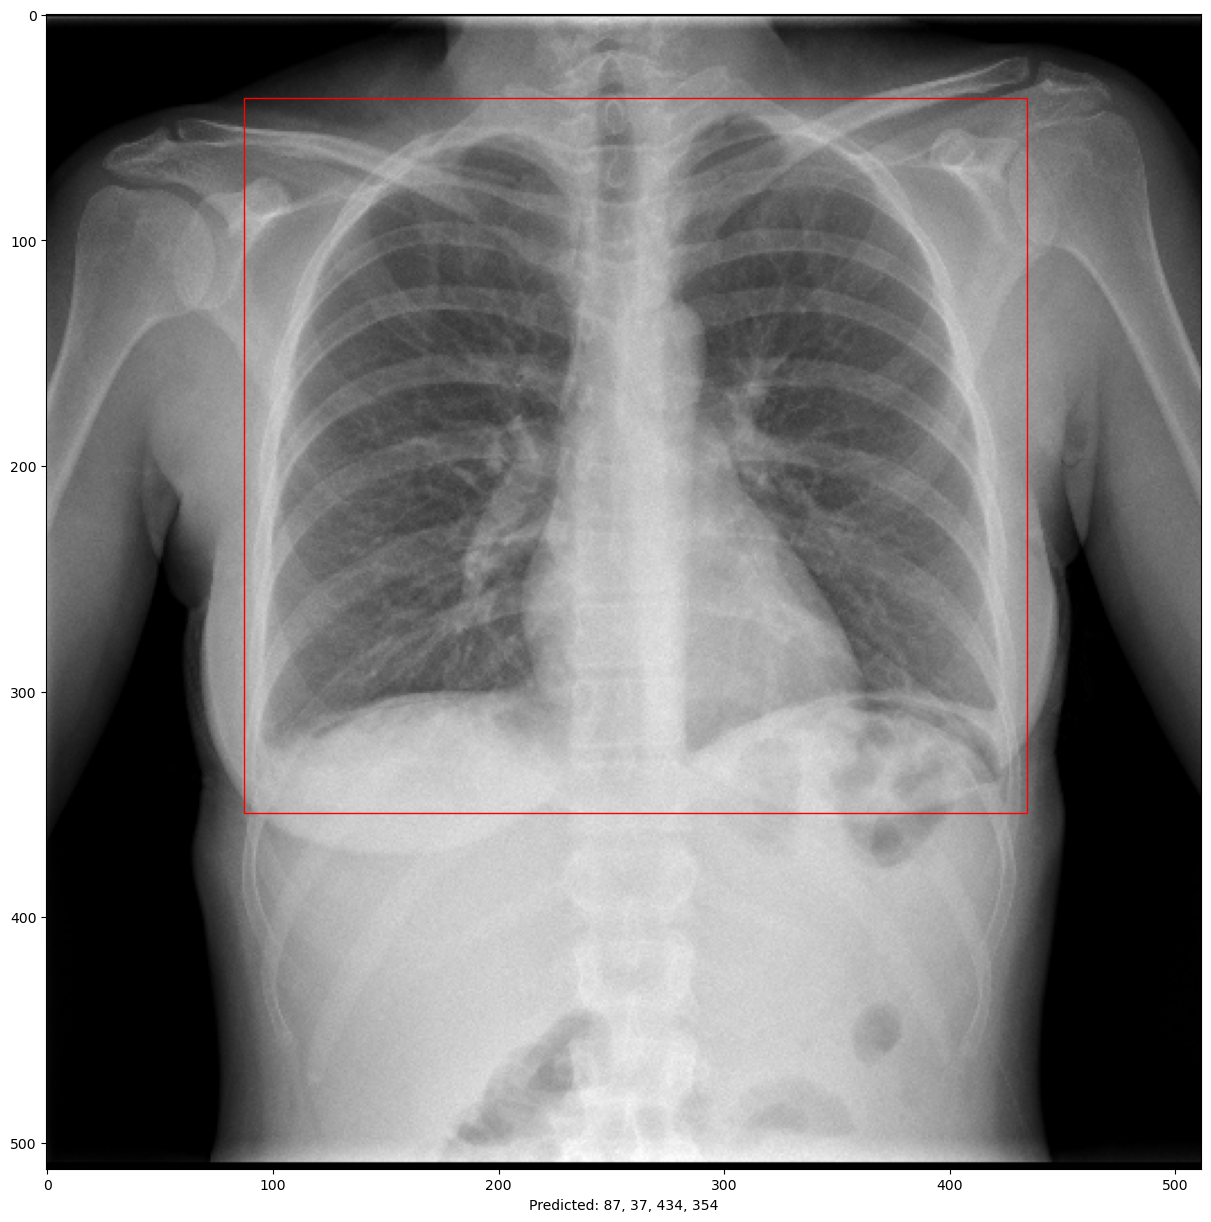

In [42]:


im = keras.utils.load_img(df.iloc[30]["ImagePath"])

image = im.resize((224,224))
im = keras.utils.img_to_array(im)


preds = model.predict(np.expand_dims(keras.utils.img_to_array(image), axis=0))[0]



original_image_size = 512 
#pad the box a little
padding = 10

top_left_x, top_left_y = max(int(preds[0] * original_image_size) - padding , 0) , max(int(preds[1] * original_image_size) - padding , 0)
 
bottom_right_x, bottom_right_y = min(int(preds[2] * original_image_size), original_image_size) + padding , min(int(preds[3] * original_image_size) + padding ,original_image_size) 




box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]


fig, (ax2) = plt.subplots(1, 1, figsize=(15, 15))
ax2.imshow(im.astype("uint8"))

rect = patches.Rectangle(
    (top_left_x, top_left_y),
    bottom_right_x - top_left_x,
    bottom_right_y - top_left_y,
    facecolor="none",
    edgecolor="red",
    linewidth=1,
)
# Add the bounding box to the image
ax2.add_patch(rect)
ax2.set_xlabel(
    "Predicted: "
    + str(top_left_x)
    + ", "
    + str(top_left_y)
    + ", "
    + str(bottom_right_x)
    + ", "
    + str(bottom_right_y)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


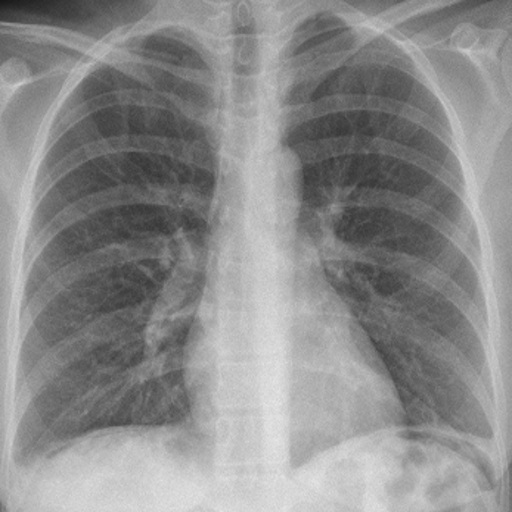

In [43]:
crop_augment( keras.utils.load_img(df.iloc[30]["ImagePath"]), model)

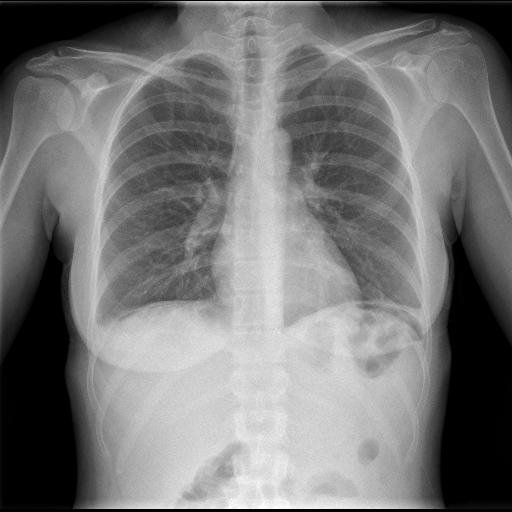

In [41]:
keras.utils.load_img(df.iloc[30]["cropPath"])

In [ ]:
keras.preprocessing.image_dataset_from_directory(
    directory=
)

In [31]:
keras.preprocessing.image.ImageDataGenerator()

AttributeError: module 'keras.preprocessing.image' has no attribute 'ImageDataGenerator'

In [32]:
train_data_padchest = pd.read_csv('/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/Data/Data_splits/pathology_detection-train.csv', index_col=0)
tube_detection_finetuning = pd.read_csv("/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/Data/Data_splits/tube_detection-finetuning.csv", index_col=0)


In [33]:
train_data_padchest

,ImageID,ImagePath,Labels,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,163878739925854469867095603268035117572_yhoxq5...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
1,216840111366964013217898866992011364092030960_...,/home/data_shares/purrlab_students/padchest-pr...,"['costophrenic angle blunting', 'copd signs', ...",0,0,0,0,0,0,0,0,0
2,216840111366964013217898866992011325102218209_...,/home/data_shares/purrlab_students/padchest-pr...,['unchanged'],0,0,0,0,0,0,0,0,0
3,216840111366964013590140476722013050135456823_...,/home/data_shares/purrlab_students/padchest-pr...,['azygos lobe'],0,0,0,0,0,0,0,0,0
4,216840111366964013217898866992012003124817926_...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
76941,216840111366964012339356563862009076083300524_...,/home/data_shares/purrlab_students/padchest-pr...,"['osteoporosis', 'kyphosis', 'hyperinflated lu...",0,0,0,0,0,0,0,0,0
76942,1275224347932024908619_00-001-124.png,/home/data_shares/purrlab_students/padchest-pr...,"['nodule', 'interstitial pattern', 'pneumonia'...",0,0,0,1,1,0,0,0,0
76943,95556550637626269114642277596726666992_cd49gw.png,/home/data_shares/purrlab_students/padchest-pr...,"['aortic atheromatosis', 'interstitial pattern...",0,0,0,0,1,0,0,0,0
76944,216840111366964013590140476722013057122257105_...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0


In [34]:
keras.losses.BinaryCrossentropy()

In [2]:
def change_paths_aug(df, data_dir):
    df = df.copy()


    df["ImagePath"] = df["ImagePath"].apply(lambda x: x.replace("/home/data_shares/purrlab_students/padchest-preprocessed/", data_dir))

    return df

In [81]:
finetune_df = pd.concat([train_data_padchest, tube_detection_finetuning])

finetune_df = finetune_df.sample(frac=1, random_state=321).reset_index(drop=True)

# Changing the image paths, so they fit to res24
finetune_df = change_paths(finetune_df)


In [82]:
finetune_df

,ImageID,ImagePath,Labels,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,216840111366964013962490064942014113131059349_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['interstitial pattern', 'costophrenic angle b...",0,0,0,0,0,0,0,0,0
1,216840111366964013451228379692012255122201257_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['hemidiaphragm elevation', 'laminar atelectas...",0,0,0,0,0,0,0,0,0
2,216840111366964013590140476722013059133334455_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['catheter', 'scoliosis']",0,0,0,0,0,0,0,0,0
3,216840111366964012558082906712010083131333134_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['adenopathy', 'consolidation']",0,0,0,0,0,0,0,0,0
4,216840111366964013686042548532013178084233850_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['pacemaker', 'costophrenic angle blunting', '...",0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
79058,216840111366964013686042548532013203084050194_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,['normal'],0,0,0,0,0,0,0,0,0
79059,216840111366964012487858717522009271125359052_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,['normal'],0,0,0,0,0,0,0,0,0
79060,216840111366964012558082906712010096101321672_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['interstitial pattern', 'pleural effusion', '...",1,0,0,0,0,0,0,0,0
79061,284595381946169957940438405728297634354_coixjs...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,['interstitial pattern'],0,0,0,0,0,0,0,0,0


In [83]:
def get_n_hot_encoding(df, labels_to_encode):
    enc = np.zeros((len(df), len(labels_to_encode)))
    for idx, row in df.iterrows():
        for ldx, l in enumerate(labels_to_encode):
            if row[l] == 1:
                enc[idx][ldx] = 1
    return enc


In [84]:
labels_to_encode_pd = ['Effusion', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly', 'Pneumonia']
y_train_pd = get_n_hot_encoding(finetune_df, labels_to_encode_pd)

In [85]:
labels_to_encode_td = ['Chest_drain_tube', 'NSG_tube', 'Endotracheal_tube', 'Tracheostomy_tube']
y_train_td = get_n_hot_encoding(finetune_df, labels_to_encode_td)

In [86]:
td_label_df = pd.DataFrame(y_train_td, columns=labels_to_encode_td)

In [87]:
td_label_df.value_counts()

Chest_drain_tube  NSG_tube  Endotracheal_tube  Tracheostomy_tube
0.0               0.0       0.0                0.0                  76946
                  1.0       0.0                0.0                   1018
                            1.0                0.0                    369
                  0.0       1.0                0.0                    227
                  1.0       0.0                1.0                    171
                  0.0       0.0                1.0                    154
1.0               0.0       0.0                0.0                    144
                  1.0       0.0                0.0                     10
                            1.0                0.0                      9
                  0.0       1.0                0.0                      7
                  1.0       0.0                1.0                      5
0.0               1.0       1.0                1.0                      2
1.0               0.0       0.0                

In [88]:
pd_label_df = pd.DataFrame(y_train_pd, columns=labels_to_encode_pd)

In [89]:
pd_label_df.value_counts()

Effusion  Pneumothorax  Atelectasis  Cardiomegaly  Pneumonia
0.0       0.0           0.0          0.0           0.0          65153
                                     1.0           0.0           6439
                                     0.0           1.0           2762
1.0       0.0           0.0          0.0           0.0           2306
                                     1.0           0.0            518
0.0       0.0           1.0          0.0           0.0            485
1.0       0.0           1.0          0.0           0.0            417
                        0.0          0.0           1.0            299
0.0       0.0           0.0          1.0           1.0            182
          1.0           0.0          0.0           0.0            173
          0.0           1.0          0.0           1.0             84
1.0       0.0           1.0          1.0           0.0             67
0.0       0.0           1.0          1.0           0.0             52
1.0       0.0           0.0  

In [90]:
pd_label_df

,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
79058,0.0,0.0,0.0,0.0,0.0
79059,0.0,0.0,0.0,0.0,0.0
79060,1.0,0.0,0.0,0.0,0.0
79061,0.0,0.0,0.0,0.0,0.0


In [91]:
td_label_df

,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
79058,0.0,0.0,0.0,0.0
79059,0.0,0.0,0.0,0.0
79060,0.0,0.0,0.0,0.0
79061,0.0,0.0,0.0,0.0


In [92]:
train_df = pd.concat([finetune_df[["ImagePath"]], pd_label_df, td_label_df], axis=1)

In [93]:
train_df

,ImagePath,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
79058,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79059,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79060,/dtu/p1/johlau/LabelReliability_and_PathologyD...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79061,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
train_df.columns

Index(['ImagePath', 'Effusion', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly',
       'Pneumonia', 'Chest_drain_tube', 'NSG_tube', 'Endotracheal_tube',
       'Tracheostomy_tube'],
      dtype='object')

In [95]:
train_df[
    (train_df['Effusion']== 0) &
    (train_df['Pneumothorax']== 0) &
    (train_df['Atelectasis']== 0) &
    (train_df['Cardiomegaly']== 0) &
    (train_df['Pneumonia']== 0) &
    (train_df['Chest_drain_tube']== 0) &
    (train_df['NSG_tube']== 0) &
    (train_df['Endotracheal_tube']== 0) &
    (train_df['Tracheostomy_tube']== 0)
][['Effusion', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly',
       'Pneumonia', 'Chest_drain_tube', 'NSG_tube', 'Endotracheal_tube',
       'Tracheostomy_tube']].value_counts()

Effusion  Pneumothorax  Atelectasis  Cardiomegaly  Pneumonia  Chest_drain_tube  NSG_tube  Endotracheal_tube  Tracheostomy_tube
0.0       0.0           0.0          0.0           0.0        0.0               0.0       0.0                0.0                  63751
Name: count, dtype: int64

In [96]:
train_df[~(
    (train_df['Effusion']== 0) &
    (train_df['Pneumothorax']== 0) &
    (train_df['Atelectasis']== 0) &
    (train_df['Cardiomegaly']== 0) &
    (train_df['Pneumonia']== 0) &
    (train_df['Chest_drain_tube']== 0) &
    (train_df['NSG_tube']== 0) &
    (train_df['Endotracheal_tube']== 0) &
    (train_df['Tracheostomy_tube']== 0))
][['Effusion', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly',
       'Pneumonia', 'Chest_drain_tube', 'NSG_tube', 'Endotracheal_tube',
       'Tracheostomy_tube']].value_counts()

Effusion  Pneumothorax  Atelectasis  Cardiomegaly  Pneumonia  Chest_drain_tube  NSG_tube  Endotracheal_tube  Tracheostomy_tube
0.0       0.0           0.0          1.0           0.0        0.0               0.0       0.0                0.0                  6391
                                     0.0           1.0        0.0               0.0       0.0                0.0                  2702
1.0       0.0           0.0          0.0           0.0        0.0               0.0       0.0                0.0                  2008
0.0       0.0           0.0          0.0           0.0        0.0               1.0       0.0                0.0                   778
1.0       0.0           0.0          1.0           0.0        0.0               0.0       0.0                0.0                   503
                                                                                                                                  ... 
0.0       1.0           0.0          0.0           0.0        1

In [97]:
train_df[
    (train_df['Effusion']== 0) &
    (train_df['Pneumothorax']== 0) &
    (train_df['Atelectasis']== 0) &
    (train_df['Cardiomegaly']== 0) &
    (train_df['Pneumonia']== 0) &
    (train_df['Chest_drain_tube']== 0) &
    (train_df['NSG_tube']== 0) &
    (train_df['Endotracheal_tube']== 0) &
    (train_df['Tracheostomy_tube']== 0)
].sample(n=15000, random_state=123)

,ImagePath,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
4871,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63981,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8956,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75960,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6856,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3429,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76429,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74169,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49190,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
sampled_df = pd.concat((train_df[~(
    (train_df['Effusion']== 0) &
    (train_df['Pneumothorax']== 0) &
    (train_df['Atelectasis']== 0) &
    (train_df['Cardiomegaly']== 0) &
    (train_df['Pneumonia']== 0) &
    (train_df['Chest_drain_tube']== 0) &
    (train_df['NSG_tube']== 0) &
    (train_df['Endotracheal_tube']== 0) &
    (train_df['Tracheostomy_tube']== 0))
], train_df[
    (train_df['Effusion']== 0) &
    (train_df['Pneumothorax']== 0) &
    (train_df['Atelectasis']== 0) &
    (train_df['Cardiomegaly']== 0) &
    (train_df['Pneumonia']== 0) &
    (train_df['Chest_drain_tube']== 0) &
    (train_df['NSG_tube']== 0) &
    (train_df['Endotracheal_tube']== 0) &
    (train_df['Tracheostomy_tube']== 0)
].sample(n=15000, random_state=123))).reset_index(drop=True)

In [99]:
sampled_df

,ImagePath,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
30307,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30308,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30309,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30310,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
train_df.columns

Index(['ImagePath', 'Effusion', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly',
       'Pneumonia', 'Chest_drain_tube', 'NSG_tube', 'Endotracheal_tube',
       'Tracheostomy_tube'],
      dtype='object')

In [102]:
train_df

,ImagePath,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
79058,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79059,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79060,/dtu/p1/johlau/LabelReliability_and_PathologyD...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79061,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data_dir = "/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/Data/"

pathology_detection_train = pd.read_csv(data_dir + 'Data_splits/pathology_detection-train.csv', index_col=0)
tube_detection_train = pd.read_csv(data_dir + "Data_splits/tube_detection-finetuning.csv", index_col=0)

train_df = pd.concat([pathology_detection_train, tube_detection_train])

pathology_detection_val = pd.read_csv(data_dir + 'Data_splits/pathology_detection-val.csv', index_col=0)
tube_detection_val = pd.read_csv(data_dir + "Data_splits/tube_detection-finetuning_val.csv", index_col=0)

val_df = pd.concat([pathology_detection_val, tube_detection_val])


In [4]:
train_df_crop = change_paths_aug(train_df, data_dir + "padchest-cropped/")
train_df = change_paths_aug(train_df, data_dir + "padchest-preprocessed/")

In [6]:
n = len(train_df)

In [7]:
train_df.iloc[int(n/2):]

,ImageID,ImagePath,Labels,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
39531,216840111366964013962490064942014106095324256_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['cardiomegaly', 'aortic elongation', 'copd si...",0,0,0,1,0,0,0,0,0
39532,124981220895507461611549004073383654393_2_5fav...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['laminar atelectasis', 'copd signs']",0,0,0,0,0,0,0,0,0
39533,216840111366964012283393834152009009112447547_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,['normal'],0,0,0,0,0,0,0,0,0
39534,312671554587912199143274430937111077510_1siwvn...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,['emphysema'],0,0,0,0,0,0,0,0,0
39535,216840111366964012558082906712010012113828232_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,['normal'],0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2112,216840111366964013590140476722013024090612764_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['pleural effusion', 'nsg tube', 'central veno...",1,0,0,0,1,0,1,0,0
2113,216840111366964012373310883942009187090700305_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['endotracheal tube', 'nsg tube', 'central ven...",0,0,0,0,0,0,1,1,0
2114,216840111366964013686042548532013192090645560_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['nsg tube', 'tracheostomy tube']",0,0,0,0,0,0,1,0,1
2115,115618656143164998074474809183697927251_v98b58...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['nsg tube', 'surgery neck', 'tracheostomy tub...",0,0,1,0,0,0,1,0,1


In [12]:
train_df.iloc[0]["ImagePath"]

'/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/Data/padchest-cropped/54/163878739925854469867095603268035117572_yhoxq5.png'

In [10]:
train_df.iloc[1]["ImagePath"]

'/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/Data/padchest-preprocessed/28/216840111366964013217898866992011364092030960_01-005-139.png'

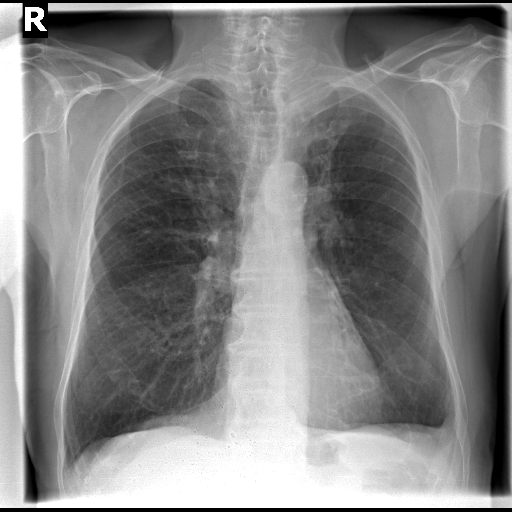

In [15]:
keras.utils.load_img(train_df.iloc[1]["ImagePath"])

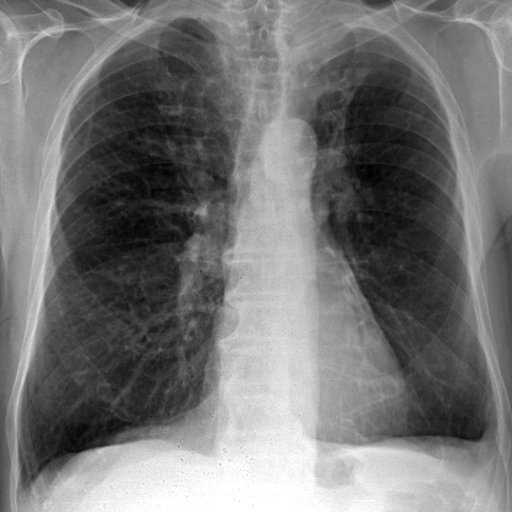

In [16]:
keras.utils.load_img(train_df_crop.iloc[1]["ImagePath"])

In [104]:
val_df

,ImageID,ImagePath,Labels,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,254279279384419775552851007267487088915_4wcbqi...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
1,216840111366964012989926673512011069122311613_...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
2,216840111366964012819207061112010300133602801_...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
3,161930867337531550944965469558051122332_l09l3o...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
4,216840111366964014008416513202014209093306334_...,/home/data_shares/purrlab_students/padchest-pr...,"['pneumonia', 'alveolar pattern']",0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1451,216840111366964012373310883942009112090054096_...,/home/data_shares/purrlab_students/padchest-pr...,"['central venous catheter via jugular vein', '...",0,0,0,0,0,0,1,0,0
1452,216840111366964013274515230432012026133850869_...,/home/data_shares/purrlab_students/padchest-pr...,"['endotracheal tube', 'nsg tube']",0,0,0,0,0,0,1,1,0
1453,216840111366964013649107288022013093131535619_...,/home/data_shares/purrlab_students/padchest-pr...,"['pleural effusion', 'nsg tube', 'tracheostomy...",1,0,0,0,1,0,1,0,1
1454,216840111366964013439197051132012220124845417_...,/home/data_shares/purrlab_students/padchest-pr...,"['pleural effusion', 'nsg tube', 'central veno...",1,0,0,0,0,0,1,0,0


In [113]:
model = keras.saving.load_model("/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/vit_object_detector_50000_samples.keras")

/zhome/4e/b/208805/.local/lib/python3.9/site-packages/keras/src/layers/layer.py:358: UserWarning: `build()` was called on layer 'patch_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
def change_paths(df):
    df = df.copy()


    df["ImagePath"] = df["ImagePath"].apply(lambda x: x.replace("padchest-preprocessed", "Modified_segmentation_masks/cropped/inside"))

    return df


In [23]:
data_dir = "/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/"

pathology_detection_test = pd.read_csv(data_dir + 'Data/Data_splits/pathology_detection-test.csv', index_col=0)
pathology_detection_test["ImagePath"] = pathology_detection_test["ImagePath"].apply(lambda x: x.replace("/home/data_shares/purrlab_students/", data_dir + "Data/"))


tube_detection_test = pd.read_csv("/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/" + "Annotation/Annotations_aggregated.csv", index_col=0)
tube_detection_test = tube_detection_test.rename({"Chest_drain":"Chest_drain_tube"},axis=1)
tube_detection_test["ImagePath"] = tube_detection_test["ImagePath"].apply(lambda x: x.replace("../../", data_dir))
tube_detection_test = tube_detection_test.replace({-1:0})



test_df = pd.concat([pathology_detection_test, tube_detection_test])

In [24]:
test_df

,ImageID,ImagePath,Labels,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube,ImageDir
0,122000277774965864047324735331704213150_58hj8t...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['hemidiaphragm elevation', 'azygos lobe']",0.0,0.0,0.0,0.0,0.0,0,0,0,0,NaN
1,323329299430220123499459743740529233555_8lonth...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['costophrenic angle blunting', 'interstitial ...",0.0,0.0,0.0,0.0,0.0,0,0,0,0,NaN
2,216840111366964013451228379692012255095015356_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,['normal'],0.0,0.0,0.0,0.0,0.0,0,0,0,0,NaN
3,215901993415805092612284930988632096429_2rbjm0...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,['callus rib fracture'],0.0,0.0,0.0,0.0,0.0,0,0,0,0,NaN
4,216840111366964013686042548532013283151248574_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,"['pacemaker', 'dual chamber device']",0.0,0.0,0.0,0.0,0.0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,315655320523004974932472015347869355953_9b6g4k...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,2.0
1007,216840111366964012819207061112010321132450050_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,49.0
1008,216840111366964014008416513202014198084124175_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,31.0
1009,216840111366964012989926673512011145120443288_...,/dtu/p1/johlau/LabelReliability_and_PathologyD...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,38.0


In [26]:
x_test_td = np.array([keras.utils.img_to_array(keras.utils.load_img(i)) for i in tqdm(tube_detection_test["ImagePath"])])

100%|██████████| 1011/1011 [00:05<00:00, 174.61it/s]


In [27]:
model_dir =  "/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/ObjectDetection/models/"

model = keras.saving.load_model(model_dir + 'mt_gamma_0.8_epochs_30.keras')

predictions = model.predict(x_test_td)

/zhome/4e/b/208805/.local/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:394: UserWarning: Skipping variable loading for optimizer 'adam', because it has 734 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


32/32 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step


In [31]:
predictions[0].shape

(1011, 5)

In [32]:
predictions[1].shape

(1011, 4)